# Simple CNN
This notebook trains a simplified version of the GoogLeNet model. # Simple CNN

## Prerequisites

- Install `tensorflow` or if running on a GPU, `tensorflow[and-cuda]`.
- Install `matplotlib`.

Configuring Tensorflow to run on a GPU is not trivial, especially in Windows. To run the latest version of Tensorlow on a GPU, it must be run in [WSL](https://learn.microsoft.com/en-us/windows/wsl/about). [This blog](https://medium.com/@ali.abulhawa/installing-tensorflow-2-16-gpu-on-windows-wsl2-df73ac3446c9) has excellent instructions on configuring a GPU for Tensorflow in WSL.

Now that Tensorflow can detect your GPU in WSL, you need to be able to run this notebook in Jupyter Lab. Follow [this blog](https://towardsdatascience.com/configuring-jupyter-notebook-in-windows-subsystem-linux-wsl2-c757893e9d69) to accomplish that feat.

In [1]:
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

2024-10-10 15:26:56.892662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 15:26:56.903152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 15:26:56.906321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 15:26:56.914049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 15:26:57.514053: W tensorflow/compiler/tf2

## Ingesting the input images

### Prepare the ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224.zip`. This zip file contains the ImageNet images used for training the CNN.
Unzip the files to a folder named `imagenet_224`. The unzipped files will have the following structure:

```
imagenet_224
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [2]:
IMAGE_DIR = os.path.join(os.getcwd(), "imagenet_224")

if not os.path.exists(IMAGE_DIR):
    raise RuntimeError(
        f"{IMAGE_DIR} not found. You need to download the ImageNet dataset and unzip it into a folder called imagenet_224")

# You can adjust the batch size depending on the compute resources
BATCH_SIZE = 16

IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,           
    validation_split=0.2,     
    subset="training",          
    seed=111,                    
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,          
    validation_split=0.2,       
    subset="validation",        
    seed=111,                    
    image_size=TARGET_SIZE,     
    batch_size=BATCH_SIZE              
)

Found 13738 files belonging to 10 classes.
Using 10991 files for training.


I0000 00:00:1728599223.984931   22446 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728599224.002998   22446 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728599224.003040   22446 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728599224.005164   22446 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728599224.005197   22446 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 13738 files belonging to 10 classes.
Using 2747 files for validation.


## Performance enhancements
Apply augmentation and prefetching to improve training performance.

In [3]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Apply the augmentation only on the training dataset
train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y))

# Prefetch the datasets for performance improvement
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Build the CNN

In [4]:
# There are 10 image classes.
NUM_CLASSES = 10

# Specify a lower learning late because of the small data set.
LEARNING_RATE = 0.0001

# Add the layers using the Functional API
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Conv2D(32, (7, 7), strides=(2, 2), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,826 (1.51 MB)

 Trainable params: 394,826 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [5]:
%%time 
# You can adjust the number of epochs as needed.
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,                        
    validation_data=validation_dataset
)

Epoch 1/30


I0000 00:00:1728599233.466489   22547 service.cc:146] XLA service 0x7fa298007190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728599233.466523   22547 service.cc:154]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-10-10 15:27:13.489831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 15:27:13.605576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  3/687 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.1319 - loss: 26.1403 

2024-10-10 15:27:19.001125: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728599239.009343   22547 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1698 - loss: 4.3965

2024-10-10 15:28:32.924829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



687/687 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.1698 - loss: 4.3939 - val_accuracy: 0.3265 - val_loss: 1.9124
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 70s 103ms/step - accuracy: 0.3097 - loss: 1.8999 - val_accuracy: 0.3535 - val_loss: 1.8849
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.3530 - loss: 1.7913 - val_accuracy: 0.4165 - val_loss: 1.6656
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.3760 - loss: 1.7243 - val_accuracy: 0.4459 - val_loss: 1.5970
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.4070 - loss: 1.6581 - val_accuracy: 0.4361 - val_loss: 1.5671
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.4195 - loss: 1.6190 - val_accuracy: 0.4529 - val_loss: 1.5452
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.4264 - loss: 1.5892 - val_accuracy: 0.4525 - val_loss: 1.5537
Epoch 8/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 71s 103ms/step - accuracy: 0.4563 - loss: 1.5439 - val

## Save training artifacts

In [6]:
# Save the model to a file.
model.save(os.path.join(os.getcwd(), "model_googlenet_simple.keras"))

# Save the history to a file.
with open(os.path.join(os.getcwd(), "history_googlenet_simple.pkl"), "wb") as file:
    pickle.dump(history, file)

## Assess the model's performance

### Plot the accuracy curve

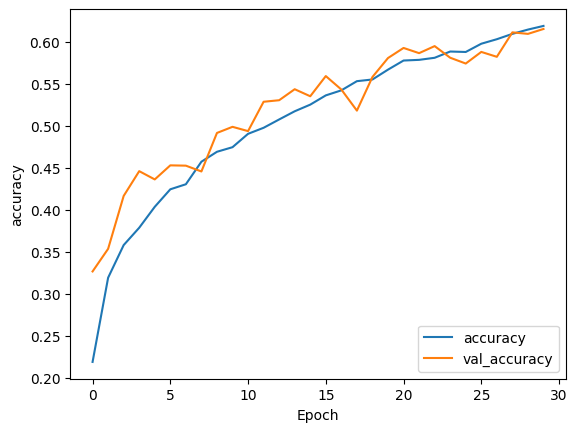

In [7]:
def plot_accuracy_curve(training_result, metric):
    val_metric = f"val_{metric}"
    train_perf = training_result.history[metric]
    validation_perf = training_result.history[val_metric]
    
    plt.plot(train_perf, label=metric)
    plt.plot(validation_perf, label=val_metric)
    
    max_val = max(validation_perf)
    max_val_epoch = validation_perf.index(max_val)
    
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(loc="lower right")
    
plot_accuracy_curve(history, "accuracy")

## Find the epoch at which the difference in training and validation accuracies are minimized.

In [8]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

acc_diff = [abs(train - val) for train, val in zip(train_acc, val_acc)]

min_diff = min(acc_diff)
min_diff_epoch = acc_diff.index(min_diff) + 1

train_acc_at_min_diff = train_acc[min_diff_epoch - 1]  
val_acc_at_min_diff = val_acc[min_diff_epoch - 1]      

print(f"Minimum difference between accuracy and validation accuracy: {min_diff:.1f} at epoch {min_diff_epoch}")
print(f"Training Accuracy at epoch {min_diff_epoch}: {train_acc_at_min_diff:.1f}")
print(f"Validation Accuracy at epoch {min_diff_epoch}: {val_acc_at_min_diff:.1f}")


Minimum difference between accuracy and validation accuracy: 0.0 at epoch 17
Training Accuracy at epoch 17: 0.5
Validation Accuracy at epoch 17: 0.5


## Evaluate the model on unseen ImageNet images.

### Prepare the evaluation ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224_eval.zip`. This zip file contains the ImageNet images used for evaluating the CNN.
Unzip the files to a folder named `imagenet_224_eval`. The unzipped files will have the following structure:

```
imagenet_224_eval
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [9]:
UNSEEN_IMAGENET_IMG_DIR = os.path.join(os.getcwd(), "imagenet_224_eval")

if not os.path.exists(UNSEEN_IMAGENET_IMG_DIR):
    raise RuntimeError(
        f"{UNSEEN_IMAGENET_IMG_DIR} not found. You need to download the ImageNet evaluation dataset and unzip it into a folder called imagenet_224_eval")

eval_imagenet_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    UNSEEN_IMAGENET_IMG_DIR,          
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE             
)

# Prefetch for better performance.
eval_imagenet_dataset = eval_imagenet_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_imagenet_dataset)

print(f"Loss on unseen ImageNet images: {loss:.1f}")
print(f"Accuracy on unseen ImageNet images: {accuracy:.1f}")

Found 1000 files belonging to 10 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6698 - loss: 1.0245
Loss on unseen ImageNet images: 1.0
Accuracy on unseen ImageNet images: 0.7


## Evaluate the model on CIFAR-10 images.

### Prepare the evaluation CIFAR-10 images
In the same directory as this notebook, you will find a file named `cifar-10.zip`. This zip file contains the ImageNet images used for evaluating the CNN against a totally different dataset - CIFAR-10.
Unzip the files to a folder named `cifar-10`. The unzipped files will have the following structure:

```
cifar-10
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [10]:
CIFAR10_IMG_DIR = os.path.join(os.getcwd(), "cifar-10")

if not os.path.exists(CIFAR10_IMG_DIR):
    raise RuntimeError(
        f"{CIFAR10_IMG_DIR} not found. You need to download the CIFAR-10 dataset and unzip it into a folder called cifar-10")

eval_cifar_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    CIFAR10_IMG_DIR,           
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

# Prefetch for better performance.
eval_cifar_dataset = eval_cifar_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_cifar_dataset)

print(f"Loss on CIFAR-10 images: {loss:.1f}")
print(f"Accuracy CIFAR-10 images: {accuracy:.1f}")

Found 10000 files belonging to 10 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1523 - loss: 4.0439
Loss on CIFAR-10 images: 4.0
Accuracy CIFAR-10 images: 0.1
